# Training the same model without pretrained word embeddings

# Processing the labels of the raw IMDB data

In [1]:
import os
train_dir = 'E:/aclImdb/aclImdb/train'
labels = []
texts = []

In [2]:
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname),encoding ='utf-8' )
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [3]:
len(texts)

25000

In [4]:
len(labels)

25000

# Tokenizing the text of the raw IMDB data

In [5]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

In [17]:
maxlen = 100
training_samples = 200
validation_samples = 10000
max_words = 10000

In [18]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 88582 unique tokens.


In [19]:
data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [20]:
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

# Parsing the GloVe word-embeddings file

In [21]:
glove_dir = 'E:/glove.6B'

embeddings_index = {}

f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'),encoding = 'utf-8')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


# Preparing the GloVe word-embeddings matrix

In [22]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Model definition

In [23]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 flatten_1 (Flatten)         (None, 10000)             0         
                                                                 
 dense_2 (Dense)             (None, 32)                320032    
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.compile(optimizer='rmsprop',
            loss='binary_crossentropy',
            metrics=['acc'])
history = model.fit(x_train, y_train,
                epochs=10,
                batch_size=32,
                validation_data=(x_val, y_val))

Epoch 1/10
7/7 [==============================] - 2s 182ms/step - loss: 0.6958 - acc: 0.5050 - val_loss: 0.6930 - val_acc: 0.5113
Epoch 2/10
7/7 [==============================] - 1s 150ms/step - loss: 0.5076 - acc: 0.9900 - val_loss: 0.6961 - val_acc: 0.5069
Epoch 3/10
7/7 [==============================] - 1s 127ms/step - loss: 0.2868 - acc: 1.0000 - val_loss: 0.7041 - val_acc: 0.5007
Epoch 4/10
7/7 [==============================] - 1s 150ms/step - loss: 0.1251 - acc: 0.9950 - val_loss: 0.7101 - val_acc: 0.5058
Epoch 5/10
7/7 [==============================] - 1s 133ms/step - loss: 0.0579 - acc: 1.0000 - val_loss: 0.7351 - val_acc: 0.5091
Epoch 6/10
7/7 [==============================] - 1s 129ms/step - loss: 0.0319 - acc: 1.0000 - val_loss: 0.7259 - val_acc: 0.5058
Epoch 7/10
7/7 [==============================] - 1s 142ms/step - loss: 0.0167 - acc: 1.0000 - val_loss: 0.7292 - val_acc: 0.5071
Epoch 8/10
7/7 [==============================] - 1s 136ms/step - loss: 0.0097 - acc: 1.00

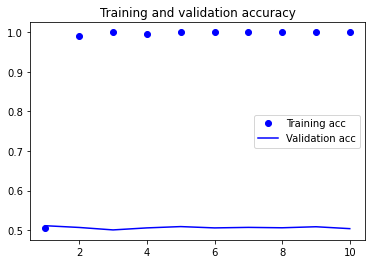

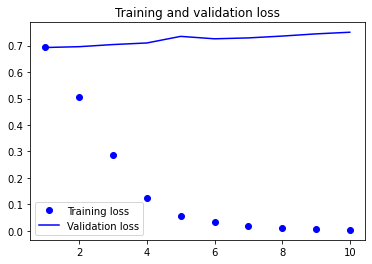

In [25]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
               
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
               
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Tokenizing the data of the test set

In [27]:
test_dir = 'E:/aclImdb/aclImdb/test'
labels = []
texts = []

In [29]:
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname),encoding = 'utf-8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [30]:
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

# Evaluating the model on the test set


In [31]:
model.evaluate(x_test, y_test)

822/822 [==============================] - 3s 3ms/step - loss: 0.7604 - acc: 0.4967


[0.7603693008422852, 0.4967494308948517]